In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy as cy
import cartopy.crs as ccrs
import matplotlib.path as mpath



In [2]:
def circle_for_polar_map(axes):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_boundary(circle, transform=axes.transAxes)

In [3]:
AR_2020_file = 'AR_detection_2020.nc4'
data_dir = '/home/jovyan/Tjaernoe2022-group5/data'
ar_2020 = xr.open_dataset(os.path.join(data_dir,AR_2020_file))

In [4]:
AR_comp_file = '20002015_AR_detection.nc'
ar_comp = xr.open_dataset(AR_comp_file)

In [7]:
ar_2020.sel(time='2020-04-15T12:00:00')#[836]

<xarray.Dataset>
Dimensions:        (lat: 361, lon: 576)
Coordinates:
  * lat            (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon            (lon) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
    time           datetime64[ns] 2020-04-15T12:00:00
Data variables:
    ar_binary_tag  (lat, lon) int8 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.0rc2 (https://mpimet.mpg...
    Conventions:  CF-1.6
    description:  ARTMIP file format (Ullrich)
    history:      Tue May  3 12:22:37 2022: ncks -4 -L 1 temp_MERRA2.ar_tag.W...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.0.0rc4 (https://mpimet.mpg...

In [104]:
val_2020 = ar_2020['ar_binary_tag'].values[:]*1.0

In [112]:
np.unique(val_2020[844,:,:]) #val_2020[844,:,:]

array([0., 1.])

In [165]:
daily_2020 = ar_2020.groupby('time.dayofyear').sum()

In [166]:
daily_2020['dayofyear'] =  np.unique(ar_2020.time.dt.floor('D'))

In [167]:
daily_2020

<xarray.Dataset>
Dimensions:        (dayofyear: 366, lat: 361, lon: 576)
Coordinates:
  * lat            (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon            (lon) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * dayofyear      (dayofyear) datetime64[ns] 2020-01-01 ... 2020-12-31
Data variables:
    ar_binary_tag  (dayofyear, lat, lon) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

In [157]:
daily_2020 = daily_2020.assign_coords({'time': np.unique(ar_2020.time.dt.floor('D'))})

In [160]:
daily_2020['ar_binary_tag'] = daily_2020.ar_binary_tag.expand_dims({'time':np.unique(ar_2020.time.dt.floor('D'))})

In [168]:
daily_2020 = daily_2020.rename({'dayofyear':'time'})

In [172]:
ar_2020.sel(time='2020-04-15T15:00:00').ar_binary_tag

<xarray.DataArray 'ar_binary_tag' (time: 8, lat: 361, lon: 576)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int8)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2020-04-15 ... 2020-04-15T21:00:00
Attributes:
    scheme:        Wille_vIVT
    description:   Binary indicator of atmospheric river using vIVT
    version:       2.4
    credits:       Developed by Jonathan D. Wille, Ambroise Dufour, Jai Chowd...
    cell_methods:  time: mean

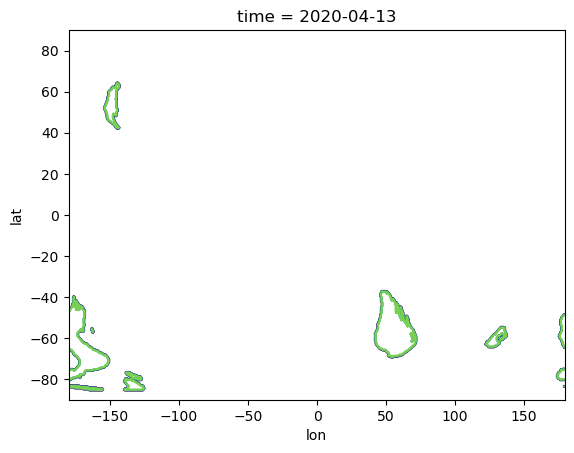

In [232]:
tst = daily_2020.sel(time='2020-04-13').ar_binary_tag.squeeze()
tst = xr.where(tst>1,1,0)

t = xr.plot.contour(tst)
#fig,ax = plt.subplots()
#ax.pcolor(ar_2020.sel(time='2020-04-15T15:00:00').ar_binary_tag.squeeze())
#xr.plot.pcolor(ar_2020.sel(time='2020-04-15T15:00:00').ar_binary_tag.squeeze())
#t = xr.plot.contour(ar_comp.sel(time='2014-03-20').ivt.squeeze(), levels=[0.0,1.0])
#plt.colorbar()
#plt.close()
#{'mpl2005', 'mpl2014', 'serial', 'threaded'}

In [227]:
[len(p) for p in t.collections[0].get_paths()]

[244, 1, 1]

In [233]:
def count_2020_ARs(ds, lat_cut):
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))
    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ar_ts = pole_ds.sel(time = ts).ar_binary_tag.squeeze()
        ar_ts = xr.where(ar_ts>1,1,0)
        ll = xr.plot.contour(ar_ts, levels=[0.0,1.0])
        plt.close()
        ar_list = np.array([len(p) for p in ll.collections[0].get_paths()])
        ar_counts[i] = len(ar_list[ar_list>20])
    ds[f'ar_counts_{lat_cut}']= ar_counts
    return ds


In [249]:
arc_2020 = count_2020_ARs(daily_2020,60)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1417: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


In [256]:
arc_2020['ar_counts_60'].sum()

<xarray.DataArray 'ar_counts_60' ()>
array(253.)

In [250]:
ant_2020 = count_2020_ARs(daily_2020,-60)

In [253]:
ant_2020['ar_counts_-60'].sum()

<xarray.DataArray 'ar_counts_-60' ()>
array(258.)

In [251]:
comp_counted = count_ARs(ar_comp, -60)

In [257]:
comp_counted_arc = count_ARs(ar_comp, 60)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1417: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


In [255]:
comp_counted['ar_counts_-60'].sum()/15

<xarray.DataArray 'ar_counts_-60' ()>
array(29.06666667)

In [258]:
comp_counted_arc['ar_counts_60'].sum()/15

<xarray.DataArray 'ar_counts_60' ()>
array(30.)

In [252]:
print('antarctic 2020=' + ant_2020['ar_counts_-60'].sum())
print('arctic 2020='+ arc_2020['ar_counts_60'].sum())

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U15'), dtype('float64')) -> None

In [239]:
def count_ARs(ds, lat_cut):
    '''
    Counts number of AR at each time step. Returns dataset with added coordinate ar_counts_[lat_cut].
    '''
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))

    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ll = xr.plot.contour(pole_ds.sel(time=ts).ivt, levels=[0.0,1.0])
        plt.close()
        if len(ll.collections)>1: #You can remove this and next line if you have run it a few times without getting the printout :))
            print('julia was wrong about something, tell her to fix it'+ts) 
        nr_ar = len(ll.collections[0].get_paths())
        ar_counts[i] = nr_ar
    ds[f'ar_counts_{lat_cut}']= ar_counts
    return ds


In [51]:
comp_counted = count_ARs(ar_comp, 60)

In [1]:
comp_counted.where(comp_counted.ar_counts_60>4)

NameError: name 'comp_counted' is not defined

In [50]:
t

In [170]:
ar_2020.loc[dict(time='2020-04-15T15:00:00')].AR_counts=1
plt.plot(ar_2020['AR_counts'])

AttributeError: cannot set attribute 'AR_counts' on a 'Dataset' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

In [223]:
day='2020-04-12'
ar_1day = ar_2020['ar_binary_tag'].sel(time=day).mean(dim='time').squeeze()

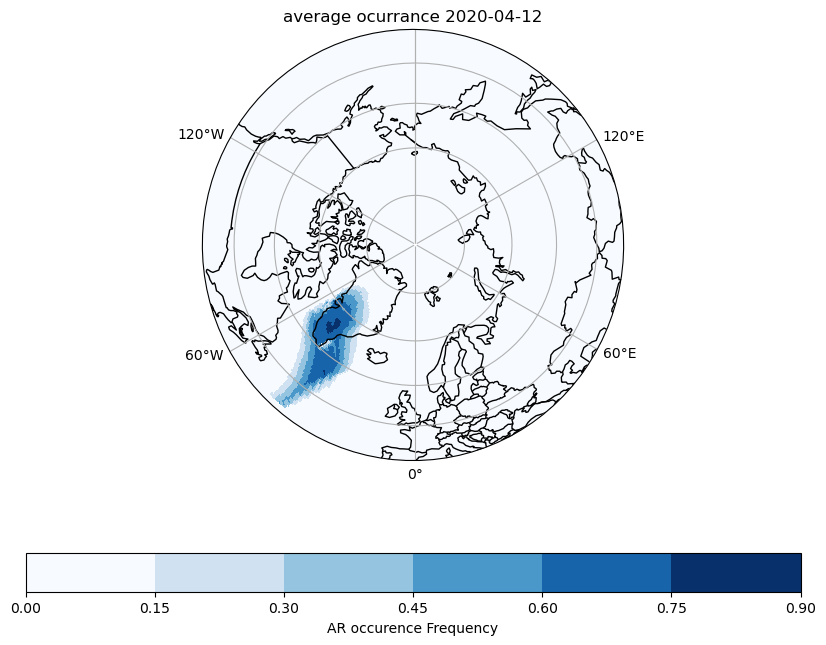

In [224]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
ar_1day.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'AR occurence Frequency', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
ax.set_title('average ocurrance {0}'.format(day))
ax.coastlines()
circle_for_polar_map(ax)
ax.set_extent([0, 360, 40, 90], ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.add_feature(cy.feature.BORDERS);

In [189]:
ar_sub = ar_2020.sel(time=slice('2020-04-14','2020-12-17'))

In [190]:
ar_sub_zep = ar_sub.sel(lat=78.9, lon = 11.8, method='nearest').squeeze()

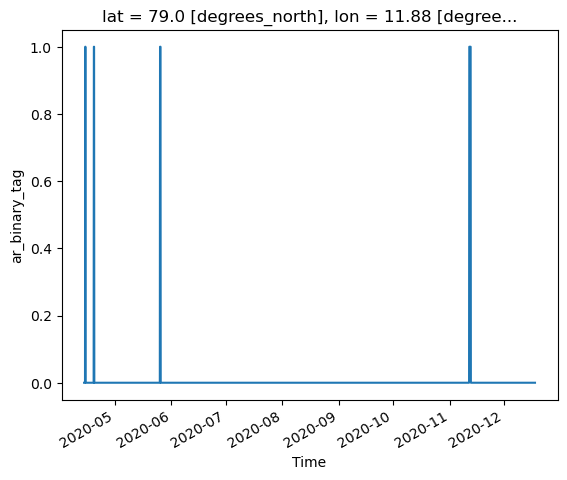

In [191]:
ar_sub_zep['ar_binary_tag'].plot()